In [28]:
# Importação de bibliotecas
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
import matplotlib.pyplot as plt


In [29]:
# Leitura dos dados experimentais (15%-10FPU)
df = pd.read_csv('../BEPE FAPESP/Dados Angarita.csv', sep=',')
df = df.rename(columns=lambda x: x.strip())
# Selecionar apenas as colunas de interesse
tempo = df['Tempo [h]'].values
Glicose = df['Glicose [g/L] 15%-10FPU'].values
Xilose = df['Xilose [g/L] 15%-10FPU'].values
Celobiose = df['Celobiose [g/L] 15%-10FPU'].values
# Remover valores nan (caso existam)
mask = ~np.isnan(Glicose)
tempo = tempo[mask]
Glicose = Glicose[mask]
Xilose = Xilose[mask]
Celobiose = Celobiose[mask]


In [30]:
# Definição das equações do modelo

def Eb(S, Emax, Ef, Kad):
    return S*Emax*Kad*Ef/(1+Kad*Ef)

def Ebc(Eb, C, S):
    return Eb * C / S if S > 0 else 0

def Ebh(Eb, H, S):
    return Eb * H / S if S > 0 else 0

def Rs(alpha, S, S0):
    return alpha * S / S0

def r1(k1r, Ebc, S, Rs, G2, G, X, K1iG, K1iG2, K1iX):
    return k1r * Ebc * S * Rs / (1 + G2 / K1iG2 + G / K1iG + X / K1iX)

def r2(k2r, Ebc, S, Rs, G2, G, X, K2iG, K2iG2, K2iX):
    return k2r * Ebc * S * Rs / (1 + G2 / K2iG2 + G / K2iG + X / K2iX)

def r3(k3r, Ef, G2, G, X, K3M, K3iG, K3iX):
    return k3r * Ef * G2 / (((1 + G / K3iG + X / K3iX) * K3M) + G2)

def r4(k4r, Ebh, Rs, S, G2, G, X, K4iG, K4iG2, K4iX):
    return k4r * Ebh * Rs * S / (1 + G2 / K4iG2 + G / K4iG + X / K4iX)

def dC_dt(r1_, r2_):
    return -r1_ - r2_

def dG2_dt(r1_, r3_):
    return 1.056 * r1_ - r3_

def dG_dt(r2_, r3_):
    return 1.111 * r2_ + 1.053 * r3_

def dH_dt(r4_):
    return -r4_

def dX_dt(r4_):
    return 1.136 * r4_


In [31]:
# Função para simular o sistema de EDOs

def modelo(t, y, params, S0):
    C, H, L, S, Ef, Eb_, G2, G, X = y
    p = params
    # 90% de Ef se torna Eb ao longo do tempo
    dEf_dt = -0.9 * Ef
    dEb_dt = 0.9 * Ef
    Eb_val = Eb_
    Ebc_val = Ebc(Eb_val, C, S)
    Ebh_val = Ebh(Eb_val, H, S)
    Rs_val = Rs(p['alpha'], S, S0)
    r1_ = r1(p['k1r'], Ebc_val, S, Rs_val, G2, G, X, p['K1iG'], p['K1iG2'], p['K1iX'])
    r2_ = r2(p['k2r'], Ebc_val, S, Rs_val, G2, G, X, p['K2iG'], p['K2iG2'], p['K2iX'])
    r3_ = r3(p['k3r'], Ef, G2, G, X, p['K3M'], p['K3iG'], p['K3iX'])
    r4_ = r4(p['k4r'], Ebh_val, Rs_val, S, G2, G, X, p['K4iG'], p['K4iG2'], p['K4iX'])
    dC = dC_dt(r1_, r2_)
    dG2 = dG2_dt(r1_, r3_)
    dG = dG_dt(r2_, r3_)
    dH = dH_dt(r4_)
    dX = dX_dt(r4_)
    dL = 0  # Lignina não reage
    dS = dC + dH + dL
    Eb = dS*p['Emax']*p['Kad']*Ef/(1+p['Kad']*Ef)
    return [
            dC, 
            dH, 
            dL, 
            dS, 
            dEf_dt, 
            dEb_dt, 
            dG2, 
            dG, 
            dX]

In [32]:
# Função de erro para ajuste dos parâmetros

def func_ajuste(param_values, param_names, t_exp, G_exp, X_exp, G2_exp, y0, S0):
    # Montar dicionário de parâmetros
    params = dict(zip(param_names, param_values))
    # Resolver EDOs
    sol = solve_ivp(lambda t, y: modelo(t, y, params, S0), [t_exp[0], t_exp[-1]], y0, t_eval=t_exp, method='LSODA', max_step=0.5)
    G_sim = sol.y[7]
    X_sim = sol.y[8]
    G2_sim = sol.y[6]
    # Erro total (Glicose, Xilose, Celobiose)
    erro = np.concatenate([
        (G_sim - G_exp),
        (X_sim - X_exp),
        (G2_sim - G2_exp)
    ])
    return erro


In [33]:
# Valores iniciais e ajuste dos parâmetros
# Fixar alpha = 1
param_names = ['Emax', 'Kad', 'k1r', 'k2r', 'k3r', 'k4r', 'K1iG2', 'K1iG', 'K1iX', 'K2iG2', 'K2iG', 'K2iX', 'K3M', 'K3iG', 'K3iX', 'K4iG2', 'K4iG', 'K4iX']
param_init = [8.32/1000, 7.16, 0.177, 8.81, 201.0, 16.34, 0.402, 2.71, 2.15, 119.6, 4.69, 0.095, 26.6, 11.06, 1.023, 16.25, 4.0, 154.0]

# Condições iniciais
biomass_composition = {'cellulose': 0.66, 'hemicellulose': 0.083, 'lignin': 0.257}
solids_loading_g_L = 150  # g/L
C0 = solids_loading_g_L * biomass_composition['cellulose']
H0 = solids_loading_g_L * biomass_composition['hemicellulose']
L0 = solids_loading_g_L * biomass_composition['lignin']
S0 = C0 + H0 + L0
Ef0 = 0.1756  # g/L
Eb0 = 0       # g/L
G20 = 0
G0 = 0
X0 = 0
y0 = [C0, H0, L0, S0, Ef0, Eb0, G20, G0, X0]

def func_ajuste_fix_alpha(param_values, param_names, t_exp, G_exp, X_exp, G2_exp, y0, S0):
    params = dict(zip(param_names, param_values))
    params['alpha'] = 1  # fixo
    params['k4r'] = 16.34  # fixo 
    # params['K4iG'] = 4.0  # fixo
    params['K4iG2'] = 16.25  # fixo
    # params['K4iX'] = 154.0  # fixo
    # params['k3r'] = 201.0  # fixo
    # params['K3M'] = 26.6  # fixo
    # params['K3iG'] = 11.06  # fixo
    # params['K3iX'] = 1.023  # fixo
    # params['k2r'] = 8.81  # fixo
    # params['K2iG'] = 2.71  # fixo
    # params['K2iG2'] = 0.402  # fixo
    # params['K2iX'] = 2.15  # fixo
    # params['k1r'] = 0.177  # fixo
    # params['K1iG'] = 7.16  # fixo
    # params['K1iG2'] = 8.32  # fixo
    # params['K1iX'] = 0.095  # fixo
    params['Emax'] = 8.32 /1000 # fixo
    params['Kad'] = 7.16  # fixo
    sol = solve_ivp(lambda t, y: modelo(t, y, params, S0), [t_exp[0], t_exp[-1]], y0, t_eval=t_exp, method='LSODA', max_step=0.5)
    G_sim = sol.y[7]
    X_sim = sol.y[8]
    G2_sim = sol.y[6]
    erro = np.concatenate([
        (G_sim - G_exp),
        (X_sim - X_exp),
        (G2_sim - G2_exp)
    ])
    return erro

# Ajuste dos parâmetros
res = least_squares(func_ajuste_fix_alpha, param_init, args=(param_names, tempo, Glicose, Xilose, Celobiose, y0, S0), bounds=(0, np.inf), verbose=2)
res = least_squares(func_ajuste_fix_alpha, param_init, args=(param_names, tempo, Glicose, Xilose, Celobiose, y0, S0), bounds=(0, np.inf), verbose=2)
param_otimos = dict(zip(param_names, res.x))
param_otimos['alpha'] = 1
print('Parâmetros ajustados:')
for k, v in param_otimos.items():
    print(f'{k}: {v:.4f}')


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.0459e+03                                    2.31e+04    
       1              2         1.0931e+03      9.53e+02       7.65e-02       5.44e+03    
       2              3         9.4508e+02      1.48e+02       4.64e-02       1.36e+03    
       3              4         9.2952e+02      1.56e+01       8.52e+00       1.71e+03    
       4              5         9.0101e+02      2.85e+01       2.83e-02       4.04e+02    
       5              7         7.8752e+02      1.13e+02       1.32e+00       2.92e+02    
       6              8         4.6445e+02      3.23e+02       2.41e+00       4.81e+02    
       7             10         3.1650e+02      1.48e+02       8.71e-01       9.46e+02    
       8             11         2.0746e+02      1.09e+02       9.06e+00       9.11e+02    
       9             12         1.7095e+02      3.65e+01       1.26e+01       6.44e+01    

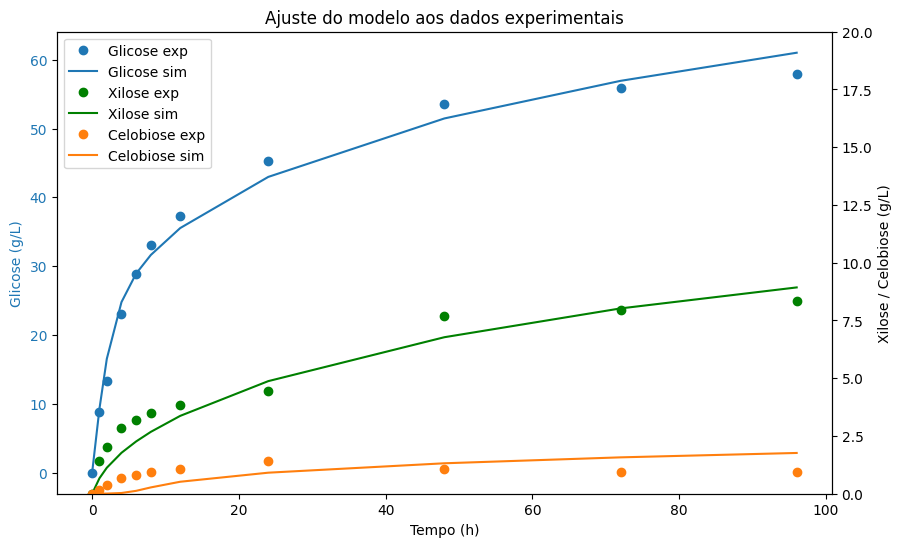

,Parâmetro,Antigo,Ajustado
0,alpha,1.000,1.000000
1,Emax,8.320,0.008320
2,Kad,7.160,7.160000
3,k1r,0.177,8.258667
4,k2r,8.810,16.301617
5,k3r,201.000,216.553170
6,k4r,16.340,16.340000
7,K1iG2,0.402,0.000341
8,K1iG,2.710,7.492430
9,K1iX,2.150,0.083099


In [34]:
# Simulação com parâmetros ajustados e comparação com dados experimentais
sol = solve_ivp(lambda t, y: modelo(t, y, param_otimos, S0), [tempo[0], tempo[-1]], y0, t_eval=tempo, method='LSODA', max_step=0.5)
G_sim = sol.y[7]
X_sim = sol.y[8]
G2_sim = sol.y[6]

fig, ax1 = plt.subplots(figsize=(10,6))

# Glicose - eixo y da esquerda
ax1.plot(tempo, Glicose, 'o', label='Glicose exp', color='tab:blue')
ax1.plot(tempo, G_sim, '-', label='Glicose sim', color='tab:blue')
ax1.set_xlabel('Tempo (h)')
ax1.set_ylabel('Glicose (g/L)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Xilose e Celobiose - eixo y da direita
ax2 = ax1.twinx()
ax2.plot(tempo, Xilose, 'o', label='Xilose exp', color='green')
ax2.plot(tempo, X_sim, '-', label='Xilose sim', color='green')
ax2.plot(tempo, Celobiose, 'o', label='Celobiose exp', color='tab:orange')
ax2.plot(tempo, G2_sim, '-', label='Celobiose sim', color='tab:orange')
ax2.set_ylabel('Xilose / Celobiose (g/L)', color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_ylim(0, 20)

# Legendas combinadas
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('Ajuste do modelo aos dados experimentais')
plt.show()

# Comparação dos parâmetros antigos e ajustados
param_nomes = ['alpha', 'Emax', 'Kad', 'k1r', 'k2r', 'k3r', 'k4r', 'K1iG2', 'K1iG', 'K1iX', 'K2iG2', 'K2iG', 'K2iX', 'K3M', 'K3iG', 'K3iX', 'K4iG2', 'K4iG', 'K4iX']
param_antigos = [1, 8.32, 7.16, 0.177, 8.81, 201.0, 16.34, 0.402, 2.71, 2.15, 119.6, 4.69, 0.095, 26.6, 11.06, 1.023, 16.25, 4.0, 154.0]
param_ajustados = [param_otimos.get(n, 1 if n=='alpha' else None) for n in param_nomes]
df_param = pd.DataFrame({'Parâmetro': param_nomes, 'Antigo': param_antigos, 'Ajustado': param_ajustados})
display(df_param)

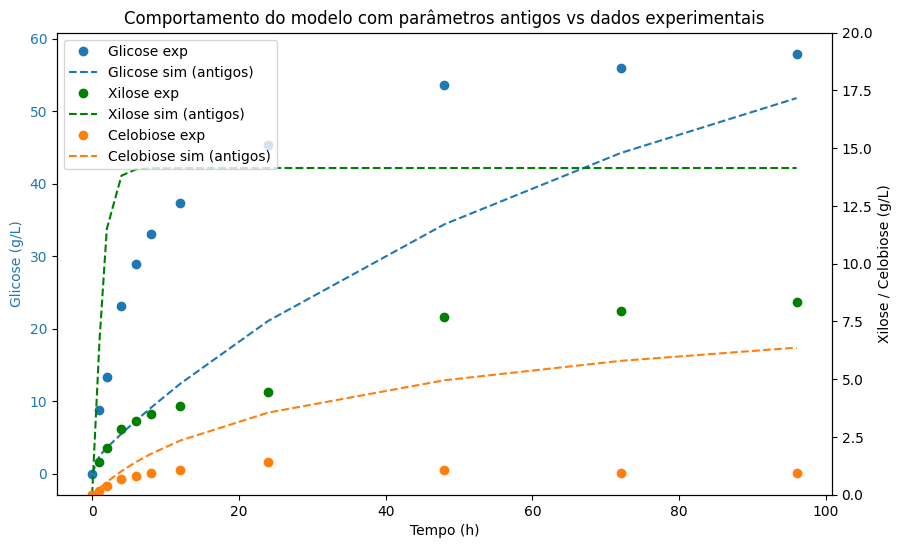

In [35]:
# Simulação com parâmetros antigos e comparação com dados experimentais
param_antigos_dict = {
    'alpha': 1,
    'Emax': 8.32/1000,
    'Kad': 7.16,
    'k1r': 0.177,
    'k2r': 8.81,
    'k3r': 201.0,
    'k4r': 16.34,
    'K1iG2': 0.402,
    'K1iG': 2.71,
    'K1iX': 2.15,
    'K2iG2': 119.6,
    'K2iG': 4.69,
    'K2iX': 0.095,
    'K3M': 26.6,
    'K3iG': 11.06,
    'K3iX': 1.023,
    'K4iG2': 16.25,
    'K4iG': 4.0,
    'K4iX': 154.0
}
sol_antigos = solve_ivp(lambda t, y: modelo(t, y, param_antigos_dict, S0), [tempo[0], tempo[-1]], y0, t_eval=tempo, method='LSODA', max_step=0.5)
G_sim_antigos = sol_antigos.y[7]
X_sim_antigos = sol_antigos.y[8]
G2_sim_antigos = sol_antigos.y[6]

fig, ax1 = plt.subplots(figsize=(10,6))

# Glicose - eixo y da esquerda
ax1.plot(tempo, Glicose, 'o', label='Glicose exp', color='tab:blue')
ax1.plot(tempo, G_sim_antigos, '--', label='Glicose sim (antigos)', color='tab:blue')
ax1.set_xlabel('Tempo (h)')
ax1.set_ylabel('Glicose (g/L)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Xilose e Celobiose - eixo y da direita
ax2 = ax1.twinx()
ax2.plot(tempo, Xilose, 'o', label='Xilose exp', color='green')
ax2.plot(tempo, X_sim_antigos, '--', label='Xilose sim (antigos)', color='green')
ax2.plot(tempo, Celobiose, 'o', label='Celobiose exp', color='tab:orange')
ax2.plot(tempo, G2_sim_antigos, '--', label='Celobiose sim (antigos)', color='tab:orange')
ax2.set_ylabel('Xilose / Celobiose (g/L)', color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_ylim(0, 20)

# Legendas combinadas
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('Comportamento do modelo com parâmetros antigos vs dados experimentais')
plt.show()

In [ ]:
# Gerar 300 pontos igualmente espaçados no intervalo de tempo experimental e criar DataFrame
try:
    tempo_modelo_300 = np.linspace(tempo[0], tempo[-1], 300)
    sol_modelo_300 = solve_ivp(lambda t, y: modelo(t, y, param_otimos, S0), [tempo_modelo_300[0], tempo_modelo_300[-1]], y0, t_eval=tempo_modelo_300, method='LSODA', max_step=0.5)
    G_sim_300 = sol_modelo_300.y[7]
    X_sim_300 = sol_modelo_300.y[8]
    G2_sim_300 = sol_modelo_300.y[6]
    df_modelo_300 = pd.DataFrame({
        'Tempo (h)': tempo_modelo_300,
        'Glicose (g/L)': G_sim_300,
        'Xilose (g/L)': X_sim_300,
        'Celobiose (g/L)': G2_sim_300
    })
    display(df_modelo_300)
    df_modelo_300
except Exception as e:
    print('Erro ao gerar os pontos do modelo:', e)

,Tempo (h),Glicose (g/L),Xilose (g/L),Celobiose (g/L)
0,0.000000,0.000000,0.000000,0.000000
1,0.321070,2.879598,0.247585,0.001076
2,0.642140,6.056703,0.465331,0.001724
3,0.963211,9.004722,0.651225,0.002448
4,1.284281,11.657542,0.814966,0.003328
...,...,...,...,...
295,94.715719,60.813312,8.888035,1.755507
296,95.036789,60.862260,8.898729,1.757779
297,95.357860,60.911065,8.909385,1.760044
298,95.678930,60.959728,8.920004,1.762302


: 